## Exersice 1

In [17]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch

# --> 1. Generate a dataset
X, y = make_moons(n_samples=1000, random_state=9)

# --> 2. Transform the dataset to tensor format
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# --> 3. Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# --> 4. Show data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train[:5], y_train[:5])

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])
tensor([[-0.5760,  0.8174],
        [ 1.6925, -0.2214],
        [ 0.0202,  0.2999],
        [ 0.9406,  0.3394],
        [ 0.6050, -0.4187]]) tensor([0., 1., 1., 0., 1.])


## Show dataset

In [18]:
import pandas as pd

df = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y': y_train})
df.head()

,x1,x2,y
0,-0.576009,0.817443,0.0
1,1.692491,-0.221426,1.0
2,0.020225,0.299895,1.0
3,0.940646,0.339389,0.0
4,0.604991,-0.418677,1.0


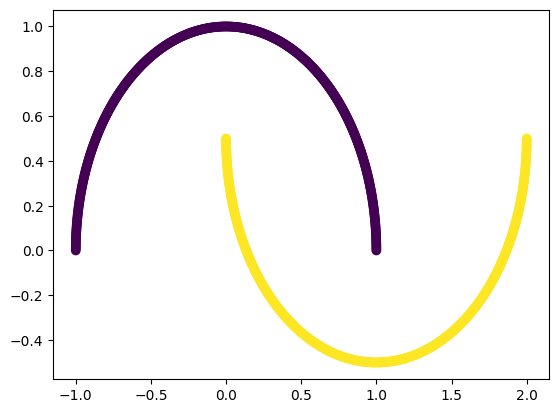

In [19]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y);

## Exersice 2

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[+] Using {device} device")

[+] Using cpu device


In [26]:
import torch.nn as nn

# --> 5. Create a model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model = MyModel().to(device)
model

MyModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## Exersice 3

In [27]:
# --> 6. Define a loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# --> 7. Define an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Exersice 4

In [28]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [29]:
torch.manual_seed(9)
epochs = 900

# --> 8. Train loop

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calcuate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68297, Accuracy: 50.62% | Test Loss: 0.68439, Test Accuracy: 47.50%
Epoch: 100 | Loss: 0.30175, Accuracy: 86.00% | Test Loss: 0.29506, Test Accuracy: 86.50%
Epoch: 200 | Loss: 0.22705, Accuracy: 89.38% | Test Loss: 0.22819, Test Accuracy: 90.50%
Epoch: 300 | Loss: 0.21568, Accuracy: 89.38% | Test Loss: 0.21897, Test Accuracy: 90.00%
Epoch: 400 | Loss: 0.20623, Accuracy: 89.75% | Test Loss: 0.21031, Test Accuracy: 89.50%
Epoch: 500 | Loss: 0.19501, Accuracy: 90.00% | Test Loss: 0.19952, Test Accuracy: 89.50%
Epoch: 600 | Loss: 0.17831, Accuracy: 90.50% | Test Loss: 0.18292, Test Accuracy: 93.00%
Epoch: 700 | Loss: 0.14867, Accuracy: 92.62% | Test Loss: 0.15264, Test Accuracy: 94.00%
Epoch: 800 | Loss: 0.10476, Accuracy: 96.25% | Test Loss: 0.10740, Test Accuracy: 97.00%


## Exersice 5

In [30]:
# --> Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([0., 1., 1., 0., 1., 1., 1., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]))

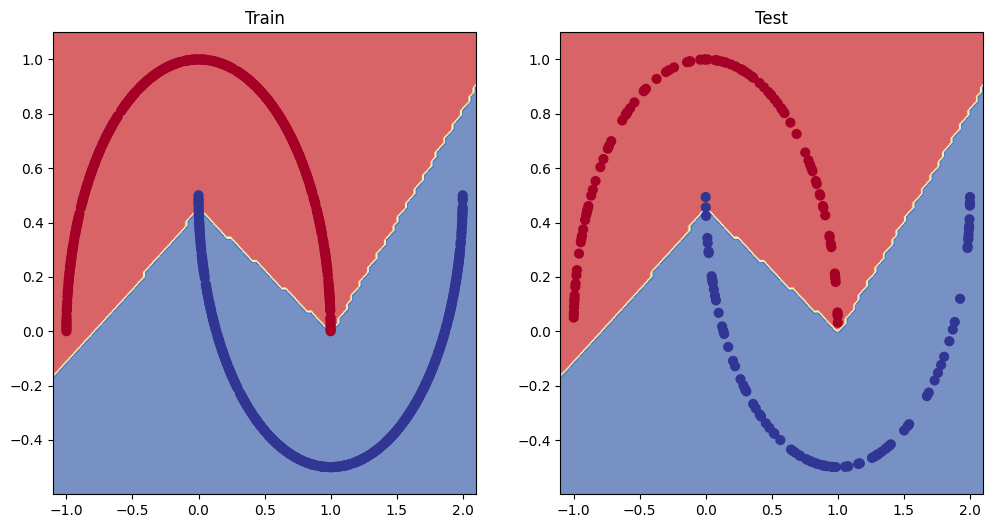

In [31]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)


## Exersice 6

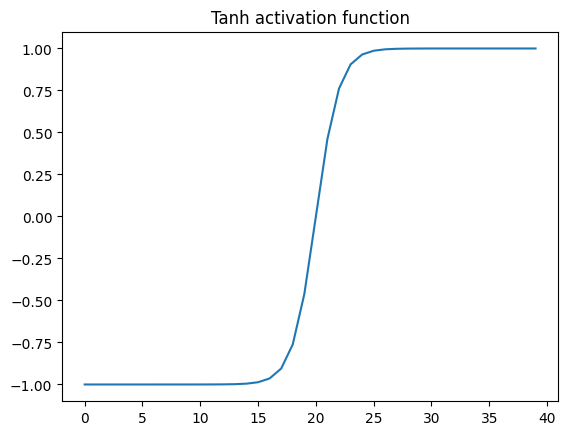

In [32]:
# --> Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

# Test the tanh function
x = torch.arange(-10, 10, 0.5)
tanh(x)

plt.plot(tanh(x))
plt.title("Tanh activation function")
plt.show()


## Exersice 7

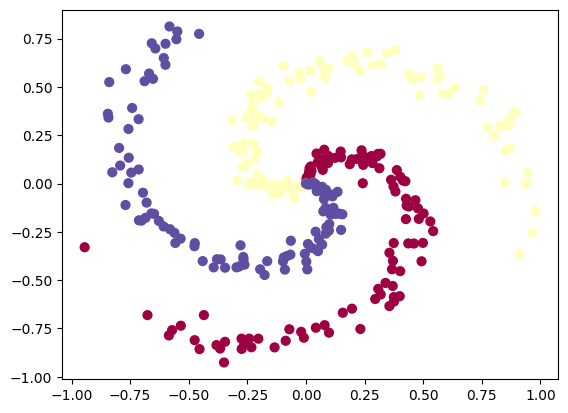

In [42]:
import numpy as np

N = 100     # number of points per class
D = 2       # dimensionality
K = 3       # number of classes
X_two = np.zeros((N*K,D)) # data matrix (each row = single example)
y_two = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X_two[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y_two[ix] = j

# lets visualize the data:
plt.scatter(X_two[:, 0], X_two[:, 1], c=y_two, s=40, cmap=plt.cm.Spectral)
plt.show()


# --> Transform the dataset to tensor format
X_two = torch.from_numpy(X_two).type(torch.float)
y_two = torch.from_numpy(y_two).type(torch.LongTensor)

# --> split the data
X_two_train, X_two_test, y_two_train, y_two_test = train_test_split(X_two, y_two, test_size=0.2, random_state=9)

In [43]:
X_two[:5], y_two[:5]

(tensor([[-0.0000,  0.0000],
         [-0.0005,  0.0101],
         [ 0.0040,  0.0198],
         [ 0.0031,  0.0301],
         [ 0.0096,  0.0392]]),
 tensor([0, 0, 0, 0, 0]))

In [44]:
class MySecondModel_(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_2 = MySecondModel_().to(device)
model_2

MySecondModel_(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [45]:
model_2(X_two_train.to(device))[:5]

tensor([[-0.1558, -0.2426, -0.0017],
        [-0.1314, -0.0711,  0.0188],
        [-0.1318, -0.3167,  0.0211],
        [-0.1523, -0.2154,  0.0080],
        [-0.1579, -0.2005,  0.0083]], grad_fn=<SliceBackward0>)

In [46]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.1)

In [47]:
torch.manual_seed(9)
epochs = 900

# --> Put data to target device
X_two_train, y_two_train = X_two_train.to(device), y_two_train.to(device)
X_two_test, y_two_test = X_two_test.to(device), y_two_test.to(device)

# --> Train loop
for epoch in range(epochs):
    ### Training
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_two_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_two_train) 
    acc = accuracy_fn(y_true=y_two_train,y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_2(X_two_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_two_test)
        test_acc = accuracy_fn(y_true=y_two_test,y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.08588, Acc: 35.42% | Test Loss: 1.04451, Test Acc: 41.67%
Epoch: 100 | Loss: 0.02248, Acc: 99.58% | Test Loss: 0.20524, Test Acc: 96.67%
Epoch: 200 | Loss: 0.01159, Acc: 99.58% | Test Loss: 0.23853, Test Acc: 96.67%
Epoch: 300 | Loss: 0.00872, Acc: 99.58% | Test Loss: 0.30012, Test Acc: 96.67%
Epoch: 400 | Loss: 0.00835, Acc: 99.58% | Test Loss: 0.38015, Test Acc: 96.67%
Epoch: 500 | Loss: 0.00722, Acc: 99.58% | Test Loss: 0.46224, Test Acc: 96.67%
Epoch: 600 | Loss: 0.00740, Acc: 99.58% | Test Loss: 0.52732, Test Acc: 96.67%
Epoch: 700 | Loss: 0.00696, Acc: 99.58% | Test Loss: 0.58705, Test Acc: 96.67%
Epoch: 800 | Loss: 0.00685, Acc: 99.58% | Test Loss: 0.63695, Test Acc: 95.00%


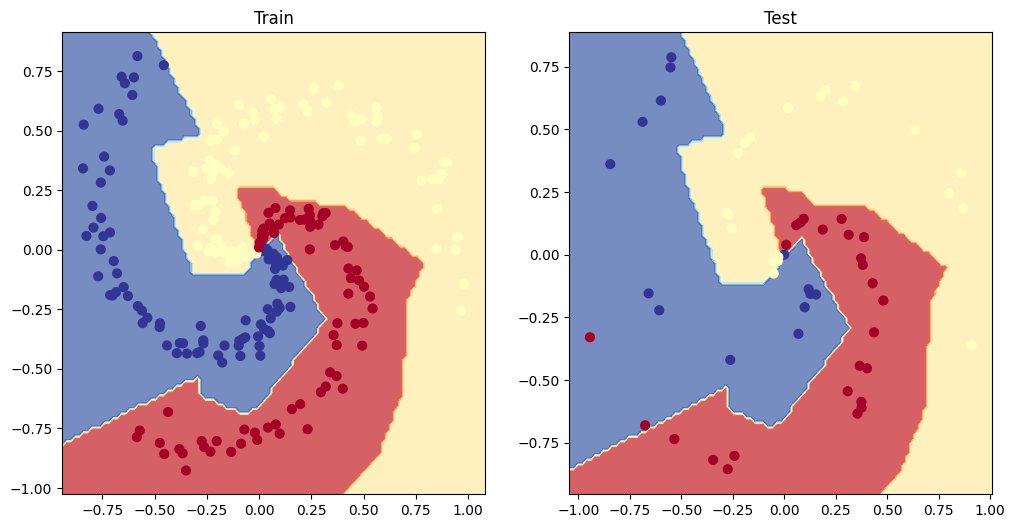

In [48]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_two_train, y_two_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_two_test, y_two_test)